In [1]:
#Import basic python librairies

import networkx as nx
import numpy as np
import pandas as pd
import random
from datetime import datetime
import numba
from numba import jit
import matplotlib.pyplot as plt

import igraph
import pylab
from igraph import *

In [2]:
# Set seed
np.random.seed(100)

In [3]:
# Function pour créer trade rates theta_ij ( powerlaw) 

power = 2.0
def create_edges_nbfils(L, power = power, tries = 1000000):  

    p=list(1 / (np.array(range(1, L)))**power) 
    p = p/sum(p)
    out_degs = list(np.random.choice(range(1, L), L, replace = True, p = p))
    ## Note, that we correct the degree sequence if its sum is odd
    if (sum(out_degs) % 2 != 0):
        out_degs[0] = out_degs[0] + 1 
        
    g = igraph.Graph.Degree_Sequence(out_degs, out_degs, method="simple")
    #g = igraph.Graph.Barabasi(L, int(L/2), directed = True, power = 1.5, outpref = True)
    g = g.simplify(multiple=True, loops=True)
    print("Number of vertices:", g.vcount())
    print("Number of edges:", g.ecount())
    
    g.es["weight"] = 1

    edges = []
    weights = []
    for e in g.es:
        edges.append(e.tuple)
        weights.append(e["weight"])
    edges = np.array(edges)
    weights = np.array(weights)
    theta_edges = np.hstack((edges, np.zeros((edges.shape[0], 1))))
    theta_edges[:,2] = weights 

    theta_edges = theta_edges.astype(float)
    theta_edges[:,2] = 1

    # To plot: 
    #for v in g.vs:
    #    v["value"] = v.index

    #g.vs["label"] = g.vs["value"]
    #out_fig_name = "graph.eps"
    #layout = g.layout("circle")
    #igraph.plot(g, out_fig_name,layout = layout)
    
    return np.array(theta_edges)

In [4]:
# FIXED PARAMETERS
L = 5000 # nombre de noeuds
#min_anim, max_anim = 20, 50 

# Trading parameters
theta_edges = create_edges_nbfils(L)

# Simulation setting
delta = 0.5
nb_steps = int(365/delta*3)

# Demographic parameters
demo_params = np.array([[1/(365*1.5), 1/(365*3)]]*L) # 1/(365*2)

print('Simulation step delta:', delta)
print('Simulated years:', nb_steps*delta/365)
print('Demographic parameters (mu and tau):', demo_params[0])

Number of vertices: 5000
Number of edges: 21050
Simulation step delta: 0.5
Simulated years: 3.0
Demographic parameters (mu and tau): [0.00182648 0.00091324]


In [5]:
# On rajoute un voisin pour les fermes sans acheteurs, et pour celles sans vendeurs
# sinon à la fin elles auront soit trop d'animaux, soit un.

def find_missing(lst): 
    return [x for x in range(0, L)
                               if x not in lst] 

sorted_receveirs =  sorted(theta_edges[:,1].astype(int))
non_receveirs = find_missing(sorted_receveirs)
theta_edges = list(theta_edges)
for i in non_receveirs:
    if i == 0:
        theta_edges.append(np.array([i+1, i, 1]))
    else:
        theta_edges.append(np.array([i-1, i, 1])) 
theta_edges = np.array(theta_edges)

sorted_givers =  sorted(theta_edges[:,0].astype(int))
non_givers = find_missing(sorted_givers)
theta_edges = list(theta_edges)
for i in non_givers:
    if i == 0:
        theta_edges.append(np.array([i, i+1, 1]))
    else:
        theta_edges.append(np.array([i, i-1, 1])) 
theta_edges = np.array(theta_edges)

#Des fois ca peut etre 1 si le seul voisin d'un node c'etait un loop, 
# je crée artificiellemnt un voisin pour ces noeuds

print('Aditionally created in-edges:', len(non_receveirs))
print('Additionally created out-edges:', len(non_givers))

Aditionally created in-edges: 0
Additionally created out-edges: 0


In [6]:
# On check le nombre minimal et maximal de voisins

a = []
b = []
for i in range(L):
    a.append(np.sum(theta_edges[:,1] == i))
    b.append(np.sum(theta_edges[:,0] == i))
    
in_deg = np.array(a)
out_deg = np.array(b)

In [7]:
# Theta edges as graph to plot and compute shortest lengths 
edges = theta_edges[:, :2].astype(int).tolist()
edges = [[str(j) for j in i] for i in edges]

# collect the set of vertex names and then sort them into a list
vertices = set()
for line in edges:
    vertices.update(line)
vertices = sorted(vertices)

# create an empty graph
g = igraph.Graph(directed = True)

# add vertices to the graph
g.add_vertices(vertices)

# add edges to the graph
g.add_edges(edges)

# set the weight of every edge to 1
g.es["weight"] = 1

# collapse multiple edges and sum their weights
g.simplify(combine_edges={"weight": "sum"})

for v in g.vs:
    v["value"] = v.index

g.vs["label"] = g.vs["value"]
# To plot:
#out_fig_name = "graph.eps"
#layout = g.layout("kk")
#plot(g, out_fig_name,layout = layout)

shortest_paths = np.array(g.shortest_paths_dijkstra(weights=None, mode=IN))

<Figure size 432x288 with 0 Axes>

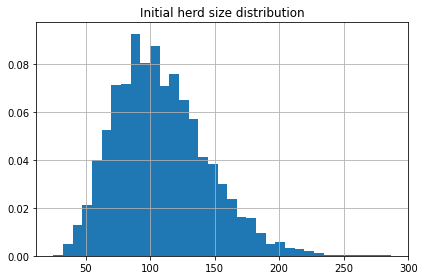

Range initial size: ( 25 , 287 )


In [8]:
# Initial size herds
N0s = np.random.gamma(9,12, L)
#N0s = np.random.gamma(3,40, L)
N0s = N0s.astype(int)
N0s_pd = pd.DataFrame(N0s)

plt.figure()
N0s_pd.hist(bins =35,  weights=np.zeros_like(N0s_pd) + 1. / N0s_pd.size)
plt.tight_layout()
plt.title('Initial herd size distribution')
plt.show()


print('Range initial size:', '(', min(N0s), ',', max(N0s), ')')

In [9]:
# Assignatio des tailles d'après le degré:

#sort thetas_i from small to big
df_out_degrees = pd.DataFrame(out_deg)
df_out_degrees['indegree']  = in_deg # add in degree to the database for later
N0s_pd  = N0s_pd.sort_values(0) 

#group creation (4 groups)
#group = np.repeat(np.array(range(0,100)), [int(L/100)]*100, axis=0)
#N0s_pd['group'] = group
#size = int(L/100)   # sample size
#replace = True  # with replacement 
#fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
#N0s_pd = N0s_pd.groupby('group', as_index=False).apply(fn)

sorted_bygroup_N0s = np.array(N0s_pd[0])

# Data frame de degrees avec N0s
df_out_degrees  = df_out_degrees.sort_values(0)
df_out_degrees['N0s'] = sorted_bygroup_N0s
df_out_degrees = df_out_degrees.sort_index()

In [10]:
N0s = np.array(df_out_degrees['N0s'])
capacities = N0s*1.5

<Figure size 432x288 with 0 Axes>

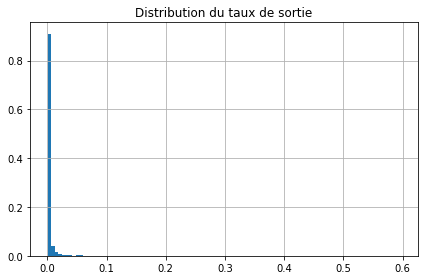

In [11]:
# Tirage de out thetas
#p=list(1 / (np.array(np.arange(0.00047, 0.00047*max(out_deg)/3,  0.000001)))**power) 
#p=list(1 / (np.array(np.arange(0.00047, 0.1, 0.000001)))**2) 
#p=list(1 / (np.array(np.arange(0.0006, 0.00076*max(out_deg)*43/1000, 0.000001)))**power) 
#p=list(1 / (np.array(np.arange(0.0006, 0.0006*np.log(max(out_deg)/10), 0.000001)))**power) 
p=list(1 / (np.array(np.arange(0.0006,  1, 0.000001)))**power) 
p = p/sum(p)
out_thetas = list(np.random.choice(np.arange(0.0006,  1,  0.000001), L, replace = True, p = p)) 
out_thetas = pd.DataFrame(out_thetas)
plt.figure()
out_thetas.hist(bins = 100,  weights=np.zeros_like(out_thetas) + 1. / out_thetas.size)
plt.tight_layout()
plt.title('Distribution du taux de sortie')
plt.show()

#sort thetas_i from small to big
out_thetas  = out_thetas.sort_values(0)

#group creation (4 groups)
#group = np.repeat(np.array(range(0,100)), [int(L/100)]*100, axis=0)
#out_thetas['group'] = group

#size = int(L/100)  # sample size
#replace = True  # with replacement ?????
#fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
#out_thetas = out_thetas.groupby('group', as_index=False).apply(fn)

sorted_bygroup_thetas_i = np.array(out_thetas[0])

In [12]:
# Data frame de degrees avec theta_i
df_out_degrees  = df_out_degrees.sort_values(0)
#df_out_degrees  = df_out_degrees.sort_values('indegree', ascending=False)
df_out_degrees['theta_i'] = sorted_bygroup_thetas_i
df_out_degrees = df_out_degrees.sort_index()

# Data frame de tailles avec theta_i
#df_NOs  = N0s_pd.sort_values(0)
#df_NOs['theta_i'] = sorted_bygroup_thetas_i
#df_NOs = df_NOs.sort_index()

#Assigner le degree par rapport à la taille
# Assignatio des tailles d'après le degré:
#sort thetas_i from small to big
#df_out_degrees = pd.DataFrame(out_deg)
#df_out_degrees  = df_out_degrees.sort_values(0)

#group creation (4 groups)
#group = np.repeat(np.array(range(0,4)), [int(L/4)]*4, axis=0)
#df_out_degrees['group'] = group

#size = int(L/4)  # sample size
#replace = True  # with replacement ?????
#fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
#df_out_degrees = df_out_degrees.groupby('group', as_index=False).apply(fn)

#sorted_bygroup_out_degrees = np.array(df_out_degrees[0])

# Data frame de tailles avec degree
#df_NOs  = df_NOs.sort_values(0)
#df_NOs['degree'] = sorted_bygroup_out_degrees
#df_NOs = df_NOs.sort_index()

In [13]:
# corr entre theta_i et out_degree
print('Spearman correlation:')
print(df_out_degrees.corr(method='spearman'))
print('Pearson correlation')
print(df_out_degrees.corr(method='pearson'))

Spearman correlation:
                 0  indegree       N0s   theta_i
0         1.000000  0.996794  0.872176  0.872163
indegree  0.996794  1.000000  0.868700  0.868703
N0s       0.872176  0.868700  1.000000  0.999959
theta_i   0.872163  0.868703  0.999959  1.000000
Pearson correlation
                 0  indegree       N0s   theta_i
0         1.000000  0.998731  0.476725  0.993509
indegree  0.998731  1.000000  0.477175  0.991373
N0s       0.476725  0.477175  1.000000  0.454808
theta_i   0.993509  0.991373  0.454808  1.000000


In [14]:
# Assign theta_i en le nombre de voisins acheteurs
for i in range(0,L):
    ijw = theta_edges[theta_edges[:,0] == i, :] 
    neighb_i = ijw[:,1].astype(int)
    theta_i_out = np.array(df_out_degrees['theta_i'])[i]
    outdeg_neighi = out_deg[neighb_i]
    indeg_neighi = in_deg[neighb_i]
    sizes_neighi = N0s[neighb_i]
    theta_neighi_out = np.array(df_out_degrees['theta_i'])[tuple([neighb_i])]
    #theta_prime = (theta_neighi_out + shortest_paths[i, neighb_i] + outdeg_neighi) /(indeg_neighi) #shortest_paths[i, neighb_i]
    theta_prime = (theta_neighi_out + shortest_paths[i, neighb_i])/indeg_neighi  # shortest_paths[i, neighb_i] #/(indeg_neighi) #shortest_paths[i, neighb_i]
    theta_i_neighi = theta_prime * theta_i_out / np.sum(theta_prime)
    theta_edges[theta_edges[:,0] == i, 2] = theta_i_neighi
    
# Splitter theta_i en le nombre de voisins acheteurs
#unique_theta_ij = np.array(df_out_degrees['theta_i'])/out_deg
#for k in range(0,L):
#    theta_edges[theta_edges[:,0] == k, 2] =  unique_theta_ij[k]

theta_pd = pd.DataFrame(theta_edges)

In [15]:
#Save fixed parameters

#Save initial number of animals by herd
np.savetxt('N0s.txt', N0s)

#Save setting (delta and nb-steps)
setting = np.array([delta, nb_steps])
np.savetxt('setting.txt', setting)

#Save demo_params
np.savetxt('demo_params.txt', demo_params)

#Save theta_edges
np.savetxt('theta_edges.txt', theta_edges)